In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

In [2]:
df = pd.read_csv("data/data.csv", sep="\t", encoding='utf-8', index_col=0)

In [3]:
df.head()

,airport1_km,airport2_km,info,latitude,longitude,person_count,price,room_size,score,sightseen_count,url,votes
0,96.0,46.8,\nДвухместный номер с 2 отдельными кроватями\n,39.863388,3.093359,2.0,20465.0,NaN,8.4,8.0,/hotel/es/pollentia-club-resort.ru.html?aid=30...,2246.0
1,73.3,59.3,\nДвухместный номер с 1 кроватью или 2 отдельн...,39.636408,3.414423,2.0,11660.0,NaN,8.9,6.0,/hotel/es/eurotel-golf-punta-rotja.ru.html?aid...,922.0
2,92.1,43.4,\nДвухместный номер с 2 отдельными кроватями\n,39.770315,3.147541,2.0,15067.0,NaN,9.1,5.0,/hotel/es/santa-fe.ru.html?aid=304142;label=ge...,501.0
3,94.4,44.1,\nДвухместный номер с 2 отдельными кроватями\n,39.812077,3.114725,2.0,11663.0,NaN,8.3,8.0,/hotel/es/alcudi-mar.ru.html?aid=304142;label=...,910.0
4,NaN,10.9,\nДвухместный номер с 1 кроватью или 2 отдельн...,39.451314,2.753180,2.0,5575.0,NaN,7.5,10.0,/hotel/es/delta.ru.html?aid=304142;label=gen17...,959.0


In [4]:
df.room_size = df.room_size.fillna(10)
df.airport1_km = df.airport1_km.fillna(150)
df.airport2_km = df.airport2_km.fillna(150)
df.votes = df.votes.fillna(0)
df.score = df.score.fillna(df.score.median())
df.sightseen_count = df.sightseen_count.fillna(0)

In [32]:
from sklearn.model_selection import train_test_split
train_indeces, test_indeces = train_test_split(range(len(df)), shuffle=True, test_size=0.2, random_state=42)

In [33]:
X = df.drop(["price", "info", "url"], axis=1).values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = df.price.values

In [34]:
X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

In [70]:
from sklearn.metrics import mean_squared_error, explained_variance_score

y_pred = y_train.mean() + np.zeros(y_test.shape)
baseline_score = np.sqrt(mean_squared_error(y_test, y_pred))
print("Baseline RMSE: ", baseline_score)

Baseline RMSE:  12911.4919172


In [231]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

def plot_score(model, model_name, X_train, y_train, param_name='alpha', param_space=np.logspace(-5, 5, 100), xscale="log"):
    errors = []

    for alpha in tqdm(param_space):
        setattr(model, param_name, alpha)
        errors.append(cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='explained_variance').mean())
    
    plt.plot(param_space, errors)
    plt.xscale(xscale)
    plt.ylabel("Explained variance")
    plt.xlabel(param_name)
    plt.title("{model_name} loss".format(model_name=model_name))
    plt.show()
        
    return errors


def show_best_score(model, model_name, param_grid, X_train, y_train, X_test, y_test):
    gs = GridSearchCV(model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='explained_variance', verbose=0)
    gs.fit(X_train, y_train)
    
    print("Best params:", gs.best_params_)
    
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_score = explained_variance_score(y_test, y_pred)
    print("{model_name} explained variance:".format(model_name=model_name), model_score)
    model_score = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{model_name} RMSE:".format(model_name=model_name), model_score)
    print("{model_name} update RMSE:".format(model_name=model_name), (baseline_score - model_score) / baseline_score)

Предположение: Данных немного, линейные модели справятся хорошо

100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


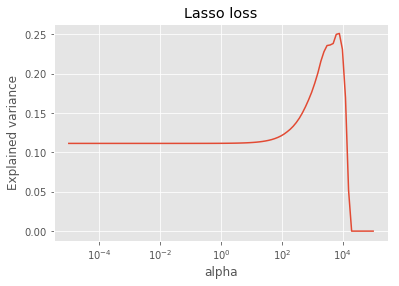

Best params: {'alpha': 7742.6368268112774}
Lasso explained variance: 0.318992115509
Lasso RMSE: 10686.7007487
Lasso update RMSE: 0.172310929113


In [213]:
plot_score(model=Lasso(), model_name='Lasso', X_train=X_train, y_train=y_train)
show_best_score(model=Lasso(), model_name='Lasso', param_grid={'alpha': np.logspace(-5, 5, 100)}, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


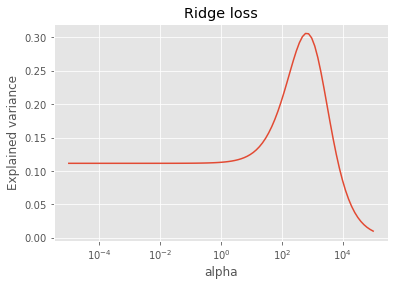

Best params: {'alpha': 599.48425031894089}
Ridge explained variance: 0.432560577155
Ridge RMSE: 9585.70023099
Ridge update RMSE: 0.257583841396


In [214]:
plot_score(model=Ridge(), model_name='Ridge', X_train=X_train, y_train=y_train)
show_best_score(model=Ridge(), model_name='Ridge',  param_grid={'alpha': np.logspace(-5, 5, 100)}, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:06<00:00, 15.69it/s]


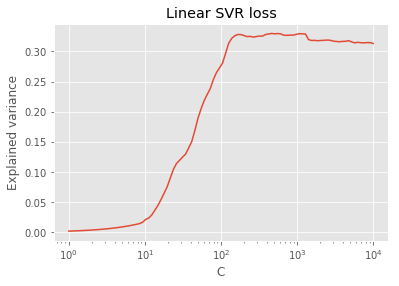

Best params: {'C': 464.15888336127819}
Linear SVR explained variance: 0.467971060518
Linear SVR RMSE: 8779.62129622
Linear SVR update RMSE: 0.320014963992


In [215]:
from sklearn.svm import SVR, LinearSVR
param_grid = {'C': np.logspace(0, 4, 100)}

plot_score(model=LinearSVR(), model_name="Linear SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=LinearSVR(), model_name='Linear SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [00:36<00:00,  2.78it/s]


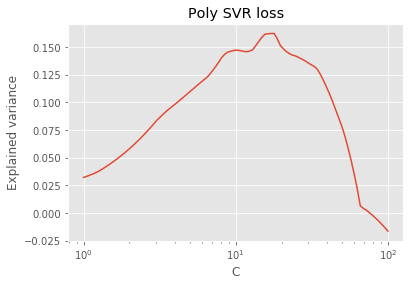

Best params: {'C': 100.0, 'degree': 2}
Poly SVR explained variance: 0.320544172193
Poly SVR RMSE: 9872.94426192
Poly SVR update RMSE: 0.235336681054


In [222]:
param_grid = {'C': np.logspace(0, 2, 100), "degree": [2, 3]}

model = SVR(kernel="poly", degree=3)

plot_score(model=model, model_name="Poly SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='Poly SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


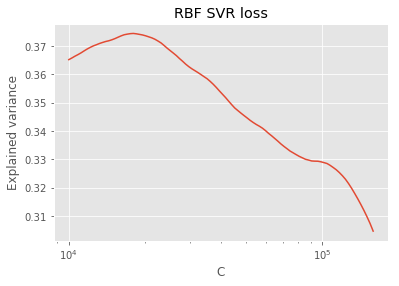

Best params: {'C': 17969.891485325956}
RBF SVR explained variance: 0.526555941333
RBF SVR RMSE: 8190.86047581
RBF SVR update RMSE: 0.365614715297


In [223]:
param_grid = {'C': np.logspace(4, 5.2, 100), }

model = SVR(kernel="rbf")

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Лучший результат - SVM с RBF ядром

Предположение:

1. [+] RBF можно улучшить, добавив координаты
1. [-] RBF поход на KNN, возможно, он покажет результаты лучше.

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


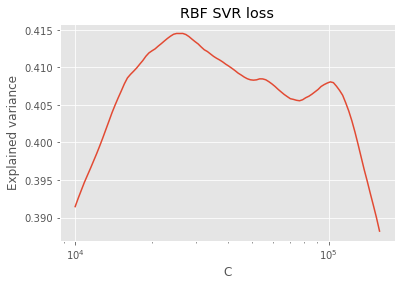

Best params: {'C': 26560.877829466841}
RBF SVR explained variance: 0.603697176174
RBF SVR RMSE: 7489.81899442
RBF SVR update RMSE: 0.419910646851


In [224]:
X = df.drop(["price", "info", "url"], axis=1).values
X -= X.mean(axis=0)
X /= X.std(axis=0)
y = df.price.values

X_train, X_test = X[train_indeces], X[test_indeces]
y_train, y_test = y[train_indeces], y[test_indeces]

param_grid = {'C': np.logspace(4, 5.2, 100), }

model = SVR(kernel="rbf")

plot_score(model=model, model_name="RBF SVR", X_train=X_train, y_train=y_train, param_name="C", param_space=param_grid["C"])
show_best_score(model=model, model_name='RBF SVR',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

100%|██████████| 45/45 [00:04<00:00,  9.99it/s]


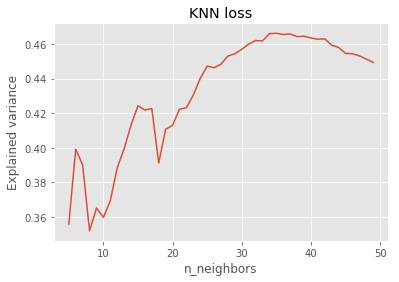

Best params: {'n_neighbors': 35}
KNN explained variance: 0.570022689584
KNN RMSE: 7897.58973904
KNN update RMSE: 0.388328646317


In [241]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(weights="distance")
param_grid = {'n_neighbors': range(5, 50) }

plot_score(model=model, model_name="KNN", X_train=X_train, y_train=y_train, param_name="n_neighbors", param_space=param_grid["n_neighbors"], xscale="linear")
show_best_score(model=model, model_name='KNN',  param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Предположение: много информации можно извлечь из названия номера

In [255]:
dictionary = dict()
for keys in df["info"].str.split():
    for key in keys:
        dictionary[key] = dictionary.get(key, 0) + 1
        
dictionary = sorted(([b, a] for a, b in dictionary.items()), reverse=True)

In [264]:
# pd.get_dummies(df["info"].str.split())
pd.get_dummies(df["info"].str.split().apply(pd.Series).stack()).sum(level=0).head()

,"""king-size""/",1,2,×,Апартаменты,Бунгало,Бюджетный,Вилла,Двухместный,Делюкс,...,кроватью,кроватями,море,на,номер,отдельными,отпуска,размера,с,сад
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
1,0,1,1,0,0,0,0,0,1,0,...,1,1,0,0,1,1,0,0,1,0
2,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
3,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
4,0,1,1,0,0,0,0,0,1,0,...,1,1,0,0,1,1,0,0,1,0


In [263]:
dictionary

[[453, 'номер'],
 [446, 'с'],
 [443, 'Двухместный'],
 [344, 'кроватью'],
 [343, '1'],
 [238, '2'],
 [237, 'отдельными'],
 [237, 'кроватями'],
 [135, 'или'],
 [92, 'Апартаменты'],
 [34, 'Вилла'],
 [33, 'Номер-студио'],
 [31, 'Люкс'],
 [23, 'отпуска'],
 [23, 'для'],
 [23, 'Дом'],
 [3, 'Трехместный'],
 [3, 'Семейный'],
 [2, 'на'],
 [2, 'и'],
 [2, 'видом'],
 [2, 'Шале'],
 [1, 'сад'],
 [1, 'размера'],
 [1, 'море'],
 [1, 'дом'],
 [1, 'двухместный'],
 [1, 'балконом'],
 [1, 'Четырехместный'],
 [1, 'Улучшенный'],
 [1, 'Общий'],
 [1, 'Мобильный'],
 [1, 'Делюкс'],
 [1, 'Бюджетный'],
 [1, 'Бунгало'],
 [1, '×'],
 [1, '"king-size"/']]